In [217]:
#############################################
# Monopoly and Prosperity
#############################################

In [218]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt


In [219]:
# Our 10-player population
population_10 = [
    { "Primary_ID": 1,  "Name": "Liam Thompson",   "Net_Worth": 1500 },
    { "Primary_ID": 2,  "Name": "Olivia Martin",   "Net_Worth": 1500 },
    { "Primary_ID": 3,  "Name": "Noah Dubois",     "Net_Worth": 1500 },
    { "Primary_ID": 4,  "Name": "Emma Roy",        "Net_Worth": 1500 },
    { "Primary_ID": 5,  "Name": "William Carter",  "Net_Worth": 1500 },
    { "Primary_ID": 6,  "Name": "Charlotte Nguyen","Net_Worth": 1500 },
    { "Primary_ID": 7,  "Name": "Benjamin Ouellette","Net_Worth": 1500 },
    { "Primary_ID": 8,  "Name": "Ava MacDonald",   "Net_Worth": 1500 },
    { "Primary_ID": 9,  "Name": "Jack Tremblay",   "Net_Worth": 1500 },
    { "Primary_ID": 10, "Name": "Sophia Leblanc",  "Net_Worth": 1500 }
]

# population_10 = [
#     { "Primary_ID": 1,  "Name": "Liam Thompson",   "Net_Worth": 1500 },
#     { "Primary_ID": 2,  "Name": "Olivia Martin",   "Net_Worth": 1500 },
#     { "Primary_ID": 3,  "Name": "Noah Dubois",     "Net_Worth": 1500 },
#     { "Primary_ID": 4,  "Name": "Emma Roy",        "Net_Worth": 1500 },
#     { "Primary_ID": 5,  "Name": "William Carter",  "Net_Worth": 1500 },
#     { "Primary_ID": 6,  "Name": "Charlotte Nguyen","Net_Worth": 1500 },
#     { "Primary_ID": 7,  "Name": "Benjamin Ouellette","Net_Worth": 1500 }
# ]

In [220]:
def load_group_into_engine(group):
    """
    group: list/tuple of 4 player dicts like:
           { "Primary_ID": ..., "Name": "...", "Net_Worth": ... }
    """
    global p_name, p_cash, p_wealth

    for i, player in enumerate(group):
        p_name[i] = player["Name"]
        # Start each engine player with this person's current net worth
        p_cash[i] = player.get("Net_Worth", 1500)

    # Initially, wealth = cash (no properties yet)
    for i in range(NUM_PLAYERS):
        p_wealth[i] = p_cash[i]


In [221]:
# Version 24 (commited into Github 29 Nov 2022)
#
# Play Monopoly and/or Prosperity.
# See the game_rules, sufficient_wealth, setup_game and play_game variables/functions for options.
# As-is, this code:
# * Starts as per normal games with all players having $1500 but no properties.
# * Plays Monopoly until the Gini coefficient exceeds 0.95 and then switches over to Prosperity and runs until all players have at least $3000.
# * Uses abbreviated London site names.


#############################################
# The Game
#############################################

# Can play either game...
game_rules = 'monopoly'
#game_rules = 'prosperity'
# Causes of finishing Monopoly...
turn = 0
gini_index = 0.0
# Causes of finishing Prosperity...
sufficient_wealth = 1500 * 2 # Twice the starting wealth (for all)

#############################################
# Output reporting control
#############################################

# Verbosity flags to aid debugging
RPT_TURN     = 1
RPT_BUY_SELL = 2
RPT_HOUSE    = 4
RPT_RENT     = 16
RPT_STATUS   = 32
RPT_CARD     = 64 # Chance / Community Chest
RPT_MONOPOLY = 128
RPT_DOUBLE   = 256
RPT_WEALTH   = 65536 # bit 17
RPT_EXPECT   = 65536*2
RPT_UNAFFORDABLE = 65536*4
# Edit to control what gets reported e.g.
report = RPT_TURN + RPT_BUY_SELL + RPT_HOUSE + RPT_RENT + RPT_STATUS + RPT_CARD + RPT_MONOPOLY + RPT_DOUBLE
report = RPT_STATUS # Concise normal information provided


#############################################
# Players in the Game
#############################################

# players and player number
NUM_PLAYERS = 4
p_name = ['Aaron', 'Brian', 'Calum', 'David'] # playing in that order

p_state = np.zeros(NUM_PLAYERS, dtype=int)
IS_FREE  = 0
IN_JAIL  = 1
IN_WORKHOUSE  = 2

p_locn    = np.zeros(NUM_PLAYERS, dtype=int)
p_cash    = np.zeros(NUM_PLAYERS, dtype=int)
p_wealth  = np.zeros(NUM_PLAYERS, dtype=int)


#############################################
# Sites on the board
#############################################

# Each site is of a particular type/group...
BROWN   = 0
CYAN    = 1
PINK    = 2
ORANGE  = 3
RED     = 4
YELLOW  = 5
GREEN   = 6
BLUE    = 7
UTILITY = 8
STATION = 9
GO      = 10
TAX     = 11
CHANCE  = 12
CHEST   = 13
GOTOJAIL    = 14
JAIL        = 15
WORKHOUSE   = 16

NUM_SITES = 40

# All the squares clockwise around the board.
site_group = [ GO,       0, CHEST,    0, TAX, STATION, 1, CHANCE,       1, 1,
              JAIL,      2, UTILITY,  2,   2, STATION, 3,  CHEST,       3, 3,
              WORKHOUSE, 4, CHANCE,   4,   4, STATION, 5,      5, UTILITY, 5,
              GOTOJAIL,  6,    6, CHEST,   6, STATION, CHANCE, 7,     TAX, 7 ]

title_price  = [ 0,  60,   0,  60,   0, 200, 100,   0, 100, 120,
                0, 140, 150, 140, 160, 200, 180,   0, 180, 200,
                0, 220,   0, 220, 240, 200, 260, 260, 150, 280,
                0, 300, 300,   0, 320, 200,   0, 350,   0, 400 ]
NOT_FOR_SALE = 0


# Edit to choose between Atlantic City and London names and between full and abbreviated site names
use_names='London'
#use_names='Atlantic City'
use_abbreviations=True

#London sites
if use_names=='London':
    if use_abbreviations:
        # Override: Abbreviated makes reports shorter and easier to view
        site_name = [     'Go..', 'OldK', 'cmch', 'Wtpl', 'InTx', 'KxSt', 'TheA', 'chnc', 'Eust', 'Pent',
                          'Jail', 'Pall', 'Elec', 'Whll', 'Nrth', 'MySt', 'BowS', 'cmch', 'Marl', 'Vine',
                          'Work', 'Strd', 'chnc', 'Flet', 'Traf', 'FnSt', 'Leic', 'Cvty', 'Wter', 'Picc',
                          'GoTo', 'Rege', 'Oxfd', 'cmch', 'Bond', 'LpSt', 'chnc', 'PkLn', 'SpTx', 'Mayf' ]
    else:
        site_name = [       'Go',   'OldKent',    'Chest', 'Whitechapel', 'IncomeTax', 'KingsCross',  'TheAngel',   'Chance', 'EustonRd', 'Pentonville',
                          'Jail',  'PallMall', 'Electric',   'Whitehall',  'Northumb', 'Marylebone', 'BowStreet',    'Chest', 'Marlboro',      'VineSt',
                     'WorkHouse', 'TheStrand',   'Chance',     'FleetSt', 'Trafalgar',  'Fenchurch', 'Leicester', 'Coventry',    'Water',  'Piccadilly',
                      'GoToJail',  'RegentSt', 'OxfordSt',       'Chest',    'BondSt',  'Liverpool',    'Chance', 'ParkLane', 'SuperTax',     'Mayfair' ]
elif use_names=='Atlantic City':
    # Note on South Carolina Ave: https://monopoly.fandom.com/wiki/North_Carolina_Avenue. Similarly on Marvin Gardens.
    if use_abbreviations:
        # Override: Abbreviated makes reports shorter and easier to view
        site_name = [ 'Go..', 'Medi',  'cmch', 'Balt', 'InTx', 'RdgR', 'Ornt', 'chnc', 'Verm', 'Conn',
                      'Jail', 'StCh',  'Elec', 'Stat', 'Virg', 'PnnR', 'St.J', 'cmch', 'Tenn', 'N.Y.',
                      'Poor', 'Kent',  'chnc', 'Indi', 'Illi', 'B&OR', 'Atln', 'Vent', 'Wter', 'Marv',
                      'Blue', 'Pcif',  'Caro', 'cmch', 'Penn', 'ShtR', 'chnc', 'PkPl', 'SpTx', 'Bdwk' ]
    else:
        site_name = [         'Go', 'Mediterranean Ave', 'Community Chest', 'Baltic Ave',      'Income Tax',       'Reading RR',      'Oriental Ave',    'Chance',          'Vermont Ave',   'Connecticut Ave',
                            'Jail', 'St. Charles Place', 'Electric Co',     'States Ave',      'Virginia Ave',     'Pennsylvania RR', 'St. James Place', 'Community Chest', 'Tennessee Ave', 'New York Ave',
                      'Poor House', 'Kentucky Ave',      'Chance',          'Indiana Ave',     'Illinois Ave',     'B&O RR',          'Atlantic Ave',    'Ventnor Ave',     'Water Works',   'Marven Gardens',
                    'Blueblood\'s', 'Pacific Ave',       'S. Carolina Ave', 'Community Chest', 'Pennsylvania Ave', 'Short Line RR',   'Chance',          'Park Place',      'Super Tax',     'Boardwalk Ave' ]
else:
    # Generic: Descriptive of groups
    site_name = [     'Go...', 'Bron1', 'cm.ch', 'Bron2', 'InTx.', 'Stat1', 'Cyan1', 'chnce', 'Cyan2', 'Cyan3',
                      'Jail.', 'Pink1', 'Util1', 'Pink2', 'Pink3', 'Stat2', 'Oran1', 'cm.ch', 'Oran2', 'Oran3',
                      'Work.', 'Red1.', 'chnce', 'Red2.', 'Red3.', 'Stat3', 'Yelo1', 'Yelo2', 'Util2', 'Yelo3',
                      'GoTo.', 'Gren1', 'Gren2', 'cm.ch', 'Gren3', 'Stat4', 'chnce', 'Blue1', 'SpTx.', 'Blue2' ]



group_name = [ 'BROWN', 'CYAN', 'PINK', 'ORANGE', 'RED', 'YELLOW', 'GREEN', 'BLUE', 'UTILITY', 'STATION', 'GO', 'TAX', 'CHANCE', 'CHEST', 'GOTOJAIL', 'JAIL', 'WORKHOUSE' ]

GO_LOCATION        = 0
JAIL_LOCATION      = 10
WORKHOUSE_LOCATION = 20



#############################################
# Ownership
#############################################


NO_PRICE = -1
NO_OWNER = -1

# Ownership of property is handled by these arrays...
site_owner = np.zeros(NUM_SITES, dtype=int)
# Rather than counting the number of properties of each group every time it is required, we maintain a count...
site_count_ownership = np.zeros((NUM_PLAYERS, 10), dtype=int)


#############################################
# Money
#############################################

community_chest = 0

def credit(player, price, info):
    p_cash[player]  += price
    #if (player == 0): print('# %5d Credit(%d)+=%d (%s)' % (p_cash[player], player, price, info))

def debit(player, price, info):
    p_cash[player]  -= price
    if (p_cash[player] < 0):
        for locn in reversed(range(NUM_SITES)): # Sell the most-expensive properties first
            if (p_cash[player] < 0) and (site_owner[locn] == player):
                if site_improvements[locn] > 0:
                    site_improvements[locn] = 0 # Sell the house that was there
                    group_improvements[site_group[locn]] -= 1
                if (report & RPT_MONOPOLY) != 0: print('INFO: %s is selling off %s to pay debts!' % (p_name[player], site_name[locn]))
                sell_property(player, locn, title_price[locn]) # And sell back to the bank (no mortgaging)
    if (p_cash[player] < 0):
        if (report & RPT_MONOPOLY) != 0: print('INFO: Bankrupt!: %s has sold off any property but is still in debt!' % (p_name[player]))
        if game_rules == 'monopoly':
            p_locn[player] = WORKHOUSE_LOCATION
            p_state[player] = IN_WORKHOUSE
            p_cash[player]    = 0 # Wipe out any remaining cash (negative values cause an incorrect Gini index calculation)
            # ...and wait until Prosperity rules are invoked

#############################################
# Ownership, Buying and Selling
#############################################

def sell_property(player, location, price):
    global site_count_ownership, site_owner
    if (report & RPT_BUY_SELL) != 0: print('# INFO: %s is selling %s for $%d' % (p_name[player], site_name[location], price))
    if site_owner[location] != player:
        print('ERROR: Property %s belongs to %s hence is not %s\'s to sell!' % (site_name[location], p_name[site_owner[location]], p_name[player]))
    else:
        site_owner[location] = NO_OWNER
        site_count_ownership[player, site_group[location]] -= 1
        credit(player, price, 'sell')

def buy_property(player, location, price):
    global site_count_ownership, site_owner
    if site_owner[location] != NO_OWNER:
        # Should already have checked this...
        print('ERROR: %s has already been bought by %s!' % (site_name[location], p_name[site_owner[location]]))
        if (report & RPT_BUY_SELL) != 0: print(site_owner)
        return False
    elif p_cash[player] < price:
        # Should already have checked this...
        print('ERROR: $%d is not enough money for %s to buy %s!' % (p_cash[player], p_name[player], site_name[location]))
        return False
    else:
        site_owner[location] = player
        if (game_rules == 'prosperity') and (site_count_ownership[player, site_group[location]] > 0):
            print('# INFO: %s trying to buy %s for $%d' % (p_name[player], site_name[p_locn[player]], title_price[p_locn[player]]))
            print('# ERROR: already has a property in this color group!')
            print(site_count_ownership)
            exit()
        site_count_ownership[player, site_group[location]] += 1
        debit(player, price, 'buy')
        if (report & RPT_BUY_SELL) != 0:
            print('# INFO: %s buys %s for $%d' % (p_name[player], site_name[p_locn[player]], title_price[p_locn[player]]))
            print('# INFO: %s now has %d properties' % (p_name[player], sum(site_count_ownership[player])))
        return True

def buy_everything(player):
    if (report & RPT_BUY_SELL) != 0: print('# INFO: %s buying everything' % (p_name[player]))
    for location in range(NUM_SITES):
        if title_price[location] != NOT_FOR_SALE :
            buy_property(player, location, title_price[location])


#############################################
# Improvements
#############################################

# For each group BROWN...BLUE + UTILITIES + STATIONS
improvement_price = [ 50, 50, 100, 100, 150, 150, 200, 200, NO_PRICE, NO_PRICE ]

def improvable_location(location):
    return (site_group[location] >= BROWN) and (site_group[location] <= BLUE)

site_improvements = np.zeros(NUM_SITES, dtype=int) # Records whether a house has been built on the site
group_improvements = np.zeros(10, dtype=int) # Determines land rent

def make_improvement(player, location):
    if (report & RPT_HOUSE) != 0: print('# INFO: %s is making an improvement on %s' % (p_name[player], site_name[location]))
    if site_owner[location] != player:
        print('ERROR: %s belongs to %s hence is not yours to improve!' % (site_name[location], p_name[site_owner[location]]))
        return False
    elif site_improvements[location] != 0:
        print('ERROR: %s has already been improved!' % (site_name[location]))
        return False
    elif improvement_price[site_group[location]] > p_cash[player]:
        print('ERROR: $%d is not enough money to improve %s!' % (p_cash[player], site_name[location]))
        return False
    elif improvable_location(location): # OK...
        price = improvement_price[site_group[location]]
        debit(player, price, 'improvement')
        site_improvements[location] = 1
        group_improvements[site_group[location]] += 1
        return True
    else:
        print('ERROR: Cannot improve %s!' % (site_name[location]))
        return False


def improve_on_everything(player):
    if (report & RPT_HOUSE) != 0: print('# INFO: %s is improving every site owned' % (p_name[player]))
    for location in range(NUM_SITES):
        if improvable_location(location):
            make_improvement(player, location)



#############################################
# Land Rent and Housing Rent
#############################################

# Indices:
UNIMPROVED = 0
# 2 and 3 house prices are used when monopolies are built.
# 4 houses and the hotel price are just provided for completeness
# -1 represents an invalid house price
# none   1    2     3     4   hotel  # site name
site_base_rent = [
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Go
 [  2,  10,  30,   90,  160,  250 ], # Mediterranean Avenue/Old Kent Rd
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Community Chest
 [  4,  20,  60,  180,  320,  450 ], # Baltic Avenue/Whitechapel Rd
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Income Tax
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Reading RR/King's Cross
 [  6,  30,  90,  270,  400,  550 ], # Oriental Avenue/The Angel, Islington
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Chance
 [  6,  30,  90,  270,  400,  550 ], # Vermont Avenue/Euston Rd
 [  8,  40, 100,  300,  450,  600 ], # Connecticut Avenue/Pentonville Rd
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Jail
 [ 10,  50, 150,  450,  625,  750 ], # St  Charles Place/Pall Mall
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Electric Company
 [ 10,  50, 150,  450,  625,  750 ], # States Avenue/Whitehall
 [ 12,  60, 180,  500,  700,  900 ], # Virginia Avenue/Northumberland Ave
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Pensylvania RR/Marylebone
 [ 14,  70, 200,  550,  750,  950 ], # St  James Place/Bow St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Community Chest
 [ 14,  70, 200,  550,  750,  950 ], # Tennessee Avenue/Marlborough St
 [ 16,  80, 220,  600,  800, 1000 ], # New York Avenue/Vine St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Just Parking
 [ 18,  90, 250,  700,  875, 1050 ], # Kentucky Avenue/Strand
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Chance
 [ 18,  90, 250,  700,  875, 1050 ], # Indiana Avenue/Fleet St
 [ 20, 100, 300,  750,  925, 1100 ], # Illinois Avenue/Trafalgar Sq
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # B&O RR/Fenchurch St
 [ 22, 110, 330,  800,  975, 1150 ], # Atlantic Avenue/Leicester Sq
 [ 22, 110, 330,  800,  975, 1150 ], # Ventnor Avenue/Coventry St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Water Works
 [ 24, 120, 360,  850, 1025, 1200 ], # Marven Gardens/Piccadilly
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Go To Jail
 [ 26, 130, 390,  900, 1100, 1275 ], # Pacific Avenue/Regent St
 [ 26, 130, 390,  900, 1100, 1275 ], # South Carolina Avenue/Oxford St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Community Chest
 [ 28, 150, 450, 1000, 1200, 1400 ], # Pennsylvania Avenue/Bond St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Short Line RR/Liverpool St
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Chance
 [ 35, 175, 500, 1100, 1300, 1500 ], # Park Place/Park Lane
 [ -1,  -1,  -1,   -1,   -1,   -1 ], # Super Tax
 [ 50, 200, 600, 1400, 1700, 2000 ]] # Boardwalk/Mayfair

num_sites_in_group     = [ 2, 3, 3, 3, 3, 3, 3, 3, 2, 4 ]

# How many properties of the same group does the owner of the location have?
def num_sites_in_group_with_the_same_owner_as(location):
    global site_owner, site_count_ownership, site_group
    if site_owner[location] == NO_OWNER:
        return 0
    else:
        return site_count_ownership[site_owner[location], site_group[location]]

# Does the owner of 'location' own any other sites in the same group?
def there_is_a_monopoly(location):
    global game_rules, site_owner, num_sites_in_group, site_group
    result = False
    if site_owner[location] == NO_OWNER:
        result = False
    else:
        the_site_group = site_group[location]
        num = num_sites_in_group_with_the_same_owner_as(location)

        if (the_site_group >= BROWN) and (the_site_group <= STATION):
            if game_rules == 'prosperity':
                # No player is allowed to own more than 1 site in a group
                result = (num > 1)
            else:
                # Notify when a player owns all sites of the same group
                result = (num == num_sites_in_group[the_site_group])
        else:
            print('ERROR: No monopoly is possible on %s!' % (site_name[location]))
            exit()
    if (result == True) and (game_rules == 'prosperity'): print('DEBUG: There is a monopoly on %s owned by %s!' % (site_name[location], p_name[site_owner[location]]))
    return result

def land_rent(location, player):
    if game_rules == 'prosperity':
         # Monopolies are broken. No multiplier effect.
        return site_base_rent[location][UNIMPROVED]
    elif (player == site_owner[location]):
        # Don't pay Land rent on own property in Monopoly
        return 0
    elif site_group[location] == UTILITY:
        # Don't bother with calculating based on die roll; just use average value 7
        if site_count_ownership[player, UTILITY] == 2:
            return 7 * 10 # If both sites owned, 10 times the roll of the dice
        else:
            return 7 * 4  # If one site owned, 4 times the roll of the dice
    elif (site_group[location] >= BROWN) and (site_group[location] <= STATION):
        # The land rent is increased based on the number of improved sites in the group
        # A site owner will benefit from others making improvements within the same group
        if site_improvements[location] == 0:
            # Increase based on the number of improvements based on OTHER sites in the group
            factor_to_be_applied = 1 + group_improvements[site_group[location]]
        else:
            # Increase based on the number of improvements on THIS and other sites in the group
            factor_to_be_applied = group_improvements[site_group[location]]
        return site_base_rent[location][UNIMPROVED] * factor_to_be_applied
    else:
        return 0

def housing_rent(location, player):
    # Monopoly: if the owner of the site owns 2 other sites in the same group,
    #           the rent is according to the classic Monopoly rules 'if 3 houses...'
    # Prosperity: the 'if 1 house...' rule always applies
    if (site_improvements[location]>0) and (player != site_owner[location]):
        if game_rules == 'monopoly':
            factor_to_be_applied = num_sites_in_group_with_the_same_owner_as(location)
            # (This should really be the number of *improved* sites.)
        else:
            factor_to_be_applied = 1 # Monopolies are broken
        if (report & RPT_EXPECT) != 0 and player==0: print('factor ', factor_to_be_applied)
        return site_base_rent[location][factor_to_be_applied]
    else: # No housing_rent chargeable
        return 0


#############################################
# Tracking divergence from equality
#############################################

def next_in_turn(player):
    return (player + 1)%NUM_PLAYERS

def report_wealth(player):
    global title_price
    running_total = p_cash[player]
    for locn in range(NUM_SITES):
        if site_owner[locn] == player:
            LP = title_price[locn]
            running_total += LP
    if (report & RPT_WEALTH) != 0: print('# report_wealth(%d): total = %d' % (player, running_total))
    return running_total

def total_outgoings(player):
    # The amount a player x would have to pay if they landed on every square
    running_total = 0
    for locn in range(NUM_SITES):
        if (site_owner[locn] != player):
            running_total += land_rent(locn, player) + housing_rent(locn, player)
            if (report & RPT_EXPECT) != 0 and player==0: print('#outgoings for %s at %12s = %d land & %d housing = %d so far' %(p_name[player], site_name[locn], land_rent(locn, player), housing_rent(locn, player), running_total))
        elif game_rules == 'prosperity':
            running_total += land_rent(locn, player) # Still have to pay land rent on your own site
            if (report & RPT_EXPECT) != 0 and player==0: print('#outgoings for %s at %12s = %d land = %d so far' %(p_name[player], site_name[locn], land_rent(locn, player), running_total))
    return running_total

# Calculate the Gini coefficient which is the ratio of
#   the area under the Lorenz curve (cumulative distribution)
# divided by
#   the area under a 'fair' Lorenz curve.
# Code is based on:
#   https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
# A more Pythonic alternative is at:
#   https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
# Modification to work better with small sample size N:
#   I am multiplying by N/(N-1) so that 'completely unfair' e.g. (0, 0, 0, 1) produces gini(x)=1 rather than (N-1)/N.
def gini_coefficient(list_of_values):
    num_samples = len(list_of_values)
    height, area = 0, 0
    for value in sorted(list_of_values):
        height += value
        area += height - value / 2.
    fair_area = height * num_samples / 2.
    result = ((fair_area - area) / fair_area)*num_samples/(num_samples-1)
    return result


#############################################
# Game turn
#############################################

def setup_game(play='fair'):
    global turn, community_chest
    global site_owner, site_count_ownership, site_improvements, group_improvements
    global p_locn, p_cash, p_state, p_wealth

    # reset counters
    turn = 0
    community_chest = 0

    # reset board ownership & improvements
    site_owner[:] = NO_OWNER
    site_count_ownership[:, :] = 0
    site_improvements[:] = 0
    group_improvements[:] = 0

    # reset player state
    p_state[:] = IS_FREE
    p_locn[:] = GO_LOCATION

    if play == 'very_unfair':
        BIG_LANDLORD = 0  # Player #0
        p_cash[:] = 1500
        p_cash[BIG_LANDLORD] = 10000
        buy_everything(BIG_LANDLORD)
        improve_on_everything(BIG_LANDLORD)
    else:
        p_cash[:] = 1500

    # starting wealth = cash (no properties yet)
    for i in range(NUM_PLAYERS):
        p_wealth[i] = p_cash[i]



def report_status():
    global gini_index
    # shows player info: cash and location, plus the cash in the community chest.
    gini_index = gini_coefficient(p_wealth)
    print('# STATUS: %d G=%.2f ' % (turn, gini_index), end='')
    for plyr in range(NUM_PLAYERS):
        print('(W%5d ' % (p_wealth[plyr]), end='')
        print( 'C%5d ' % (p_cash[plyr]), end='')
        print(  '%s)' % (site_name[p_locn[plyr]]), end='')
    print(' $%d' % (community_chest))

def summarize_sites():
    print('# SITES: ', end='')
    for l in range(NUM_SITES):
        if (site_group[l]>STATION):
            print('.', end='') # Can't buy
        elif (site_owner[l] == NO_OWNER):
            print('-', end='') # Not bought
        elif (site_improvements[l] > 0): # Has a house on it
            name = p_name[site_owner[l]]
            print('%s' % (name[0].upper()), end='') # Upper case initial
        else: # No house
            name = p_name[site_owner[l]]
            print('%s' % (name[0].lower()), end='') # Lower case initial
    print('')


def i_can_afford_it(player, price): # Based on my cash being higher than that required in the next few rounds!
    return price < (p_cash[player] - total_outgoings(player))


def game_turn(player, dice_throw):
    global p_locn
    global p_cash
    global p_wealth
    global site_owner
    global site_count_ownership
    global site_group
    global site_improvements
    global community_chest
    global report
    global turn

    # 1. Stuck in the Workhouse
    # 2. Stuck in Jail
    # 3. Collecting $200 for passing Go (possibly building houses)
    if (p_state[player] == IN_WORKHOUSE) and (p_cash[player] <= 0):
        # To leave the workhouse, you must have some money.
        # Having lost everything, you will only get money via the Community Chest
        pass
    elif (p_state[player] == IN_JAIL) and not threw_a_double(dice_throw):
        # In this program: the only way out of jail is to (eventually) throw a double
        pass
    else:
        p_state[player] = IS_FREE
        p_locn[player] = (p_locn[player] + dice_throw[0] + dice_throw[1])
        if p_locn[player] >= NUM_SITES:
            p_locn[player] -= NUM_SITES # Module 40 position
            credit(player, 200, 'go')
            if (report & RPT_TURN) != 0: print('# INFO: %s collecting $200 for passing GO' % (p_name[player]))
            # Allowed to build houses when passing GO...
            for location in range(NUM_SITES):
                # Put houses on cheapest properties first (gradually build up)
                if (site_owner[location] == player) and improvable_location(location):
                    if not (site_improvements[location]) and i_can_afford_it(player, improvement_price[site_group[location]]):
                        make_improvement(player, location)
        if (report & RPT_TURN) != 0: print('# INFO: %s rolled %d and is now at %s (%s)' % (p_name[player], dice_throw[0]+dice_throw[1], site_name[p_locn[player]], group_name[site_group[p_locn[player]]]))

    # What to do depends on what square you have ended up on...
    if site_group[p_locn[player]]== GO:
        if (report & RPT_TURN) != 0: print('# INFO: %s is at GO' % (p_name[player]))
        pass # Will have already collected $200
    elif site_group[p_locn[player]]== WORKHOUSE:
        if (p_state[player] == IS_FREE):
            if (report & RPT_TURN) != 0: print('# INFO: %s is just visiting the Workhouse' % (p_name[player]))
    elif site_group[p_locn[player]]== JAIL: # Now 'Just Visiting'
        if (p_state[player] == IS_FREE):
            if (report & RPT_TURN) != 0: print('# INFO: %s is just visiting jail' % (p_name[player]))
    elif site_group[p_locn[player]]== GOTOJAIL:
        if game_rules == 'monopoly':
            if (report & RPT_TURN) != 0: print('# INFO: %s goes to jail for trespassing on Lord Blueblood\'s land!' % (p_name[player]))
            p_locn[player]  = JAIL_LOCATION
            p_state[player] = IN_JAIL
        else:
            if (report & RPT_TURN) != 0: print('# INFO: %s is just visiting Blueblood\'s park' % (p_name[player]))
        pass
    elif site_group[p_locn[player]]== TAX:
        if game_rules == 'prosperity':
            if (report & RPT_TURN) != 0: print('# INFO: %s does not need to pay any taxes other than Land Value Tax!' % (p_name[player]))
        elif site_name[p_locn[player]] == 'IncomeTax':
            if (report & RPT_TURN) != 0: print('# INFO: %s is paying $200 income tax' % (p_name[player]))
            debit(player, 200, 'income tax')
        else:
            if (report & RPT_TURN) != 0: print('# INFO: %s is paying $100 super tax' % (p_name[player]))
            debit(player, 100, 'super tax')
    elif site_group[p_locn[player]]== CHANCE: # Now 'Absolute Necessity' $10
        if (report & RPT_TURN) != 0:
            if(game_rules == 'prosperity'):
                if (p_wealth[player] > 10):
                    if (report & RPT_CARD) != 0: print('# INFO: %s is paying $10 for an Absolute Necessity' % (p_name[player]))
                    debit(player, 10, 'chance')
                    community_chest      += 10
            else:
                # Local rules: have the option to take a Chance card.
                # In this automated game, always choose not to.
                print('# INFO: %s has decided not to take a chance' % (p_name[player]))
    elif site_group[p_locn[player]]== CHEST: # Community Chest
        if (game_rules == 'monopoly'):
            # Local rules: have the option to take a Community Chest card.
            # In this automated game, always choose not to.
            if (report & RPT_TURN) != 0: print('# INFO: %s does not get involved with the Community Chest' % (p_name[player]))
        else: # prosperity
            if community_chest > NUM_PLAYERS: # Sharing out: At least $1 to distribute!
                if (report & RPT_CARD) != 0: print('# Distributing the Community Chest')
                fee = community_chest // NUM_PLAYERS # (floor division)
                for plyr in range(NUM_PLAYERS):
                    if (report & RPT_CARD) != 0: print('# INFO: %s is receiving $%d from the Community Chest' % (p_name[plyr], fee))
                    credit(plyr, fee, 'payout')
                    community_chest      -= fee
    else: # A group site (housing color, station or utility)
        ###print('DEBUG_POINT3')
        #################################
        # Should there be a forced sale? (to break a monopoly)
        #################################
        ##if there_is_a_monopoly(p_locn[player]):
        #if (game_rules == 'prosperity'):
        #    #if num_sites_in_group_with_the_same_owner_as(p_locn[player]) > 1:
        #    if site_count_ownership[site_owner[p_locn[player]], site_group[p_locn[player]]] > 1:
        #        print('DEBUG_POINT3 AT %s' % (site_name[p_locn[player]]))
        #######        print(site_count_ownership)
        #if num_sites_in_group_with_the_same_owner_as(p_locn[player]) > 1:
        if site_count_ownership[site_owner[p_locn[player]], site_group[p_locn[player]]] > 1:
            if (game_rules == 'prosperity') and (player != site_owner[p_locn[player]]):
                # Monopoly only broken if the player landing on the site is not the monopoly owner!
                ######summarize_sites()
                if (report & RPT_BUY_SELL) != 0:
                    print('# INFO: %s is forced to sell %s to break monopoly' % (p_name[site_owner[p_locn[player]]], site_name[p_locn[player]]))
                    print(site_count_ownership)
                # Reimburse for any improvement:
                if site_improvements[p_locn[player]] == 1:
                    site_improvements[p_locn[player]] = 0
                    credit(site_owner[p_locn[player]], improvement_price[site_group[p_locn[player]]], 'reimbursement')
                sell_property(site_owner[p_locn[player]], p_locn[player], title_price[p_locn[player]])
        #################################
        # Will the site be bought?
        #################################
        ###print('DEBUG_POINT4')
        ###print(site_owner[p_locn[player]])
        ####print(title_price[p_locn[player]])
        if site_owner[p_locn[player]] == NO_OWNER:
            ###print('DEBUG_POINT3')
            price_to_buy = title_price[p_locn[player]]
            if i_can_afford_it(player, price_to_buy):
                ##########if (report & RPT_BUY_SELL) != 0: print('# INFO: %s is buying %s for $%d' % (p_name[player], site_name[p_locn[player]], price_to_buy))
                count = site_count_ownership[player, site_group[p_locn[player]]]
                #if (game_rules == 'prosperity') and there_is_a_monopoly(p_locn[player]):
                if (game_rules == 'prosperity') and (count > 0):
                    if (report & RPT_BUY_SELL) != 0: print('# INFO: %s not allowed to buy %s' % (p_name[player], site_name[p_locn[player]]))
                    ####print('DEBUG_POINT7')
                else:
                    ######summarize_sites() ##### DEBUG to see why players can buy towards a monopoly...
                    ######print(num_sites_in_group_with_the_same_owner_as(p_locn[player]))
                    #####print(there_is_a_monopoly(p_locn[player]))
                    buy_property(player, p_locn[player], price_to_buy)
                    #####print(site_count_ownership) ##### DEBUG to see why players can buy towards a monopoly...
            else:
                if (report & RPT_UNAFFORDABLE) != 0: print('# INFO: %s cannot afford to buy %s' % (p_name[player], site_name[p_locn[player]]))

        #################################
        # Will rent be paid?
        #################################
        if (player != site_owner[p_locn[player]]):
            if (report & RPT_TURN) != 0: print('# INFO: %s owns %s' % (p_name[site_owner[p_locn[player]]], site_name[p_locn[player]]))
            fee = land_rent(p_locn[player], player)
            if (game_rules == 'prosperity'):
                # Pay Land Rent to the Community Chest (including owners of the site)
                if (report & RPT_RENT) != 0: print('# INFO: %s is paying $%d Land Rent for %s' % (p_name[player], fee, site_name[p_locn[player]]))
                debit(player, fee, 'land rent')
                community_chest      += fee
            elif player != site_owner[p_locn[player]]: # monopoly rules
                # Pay Land Rent to the owner
                if (report & RPT_RENT) != 0: print('# INFO: %s is paying $%d Land Rent to %d for %s' % (p_name[player], fee, site_owner[p_locn[player]], site_name[p_locn[player]]))
                debit(player, fee, 'land rent')
                credit(site_owner[p_locn[player]], fee, 'let land')
                # Pay Housing Rent to the owner if applicable
                if player != site_owner[p_locn[player]]:
                    fee = housing_rent(p_locn[player], player)
                    if (report & RPT_RENT) != 0: print('# INFO: %s is paying $%d House Rent to %d for %s' % (p_name[player], fee, site_owner[p_locn[player]], site_name[p_locn[player]]))
                    debit(player, fee, 'house rent')
                    credit(site_owner[p_locn[player]], fee, 'let house')
        # (Code is not implementing the jump +/-8 rule on stations)

    for player2 in range(NUM_PLAYERS):
        p_wealth[player2] = report_wealth(player2)

    # Running status:
    # shows player info: cash, 'gain' and location, plus the cash in the community chest.
    # 'Gain' is an estimate of how quickly cash will increase or (if negative) decrease.
    if ((report & RPT_STATUS) != 0): report_status()
    ######if report_the_status: summarize_sites()

#############################################
# Game play
#############################################

def threw_a_double(dice_throw):
    return dice_throw[0] == dice_throw[1]

In [222]:
def play_game(max_turns, max_gini):
    global p_locn, p_cash, site_owner, site_count_ownership, site_improvements
    global turn, game_rules, report, gini_index, p_wealth, sufficient_wealth
    global p_state

    print('#####################')
    if game_rules == 'prosperity':
        print("# Let's play Prosperity!")
    elif game_rules == 'monopoly':
        print("# Let's play Monopoly!")
    else:
        print('# ERROR: Bad game')
        exit()

    # ---------- Prosperity special rules ----------
    # We define thresholds based on the *starting* wealth
    prosperity_double_mode = False
    per_player_double_targets = None  # list of length NUM_PLAYERS

    if game_rules == 'prosperity':
        # take a snapshot of starting wealth for this game
        starting_wealth = [p_wealth[i] for i in range(NUM_PLAYERS)]
        all_above = all(w >= sufficient_wealth for w in starting_wealth)

        if all_above:
            # if everyone already ≥ 3000: each player gets their own doubled target
            prosperity_double_mode = True
            per_player_double_targets = [2 * w for w in starting_wealth]
            print('# Prosperity double-mode:')
            for i in range(NUM_PLAYERS):
                print(f'#   {p_name[i]}: start={starting_wealth[i]}, target={per_player_double_targets[i]}')
        else:
            # otherwise: classic Prosperity rule (everyone to ≥ sufficient_wealth)
            print(f'# Prosperity standard-mode: play until all players reach ≥ ${sufficient_wealth}')

    # ---------- Main loop ----------
    turn = 1
    player = 0  # fixed starting player
    finish = False

    while (turn <= max_turns) and not finish:
        # Player stuck in Workhouse with no money
        if (site_group[p_locn[player]] == WORKHOUSE) and (p_cash[player] < 0):
            if (report & RPT_TURN) != 0:
                print('# INFO: %s is stuck in the Workhouse' % (p_name[player]))
        else:
            if (report & RPT_TURN) != 0:
                print('# INFO: %s is at %s at start of turn %d with $%d' %
                      (p_name[player], site_name[p_locn[player]], turn, p_cash[player]))

            # First roll
            dice_throw = [random.randint(1, 6), random.randint(1, 6)]
            game_turn(player, dice_throw)

            # Handle doubles (up to 3 throws)
            if threw_a_double(dice_throw):
                if (report & RPT_DOUBLE) != 0:
                    print('# INFO: Another go because %s threw a double' %
                          (p_name[player]))
                dice_throw = [random.randint(1, 6), random.randint(1, 6)]
                game_turn(player, dice_throw)

                if threw_a_double(dice_throw):
                    if (report & RPT_DOUBLE) != 0:
                        print('# INFO: Another go because %s threw a second double' %
                              (p_name[player]))
                    dice_throw = [random.randint(1, 6), random.randint(1, 6)]
                    game_turn(player, dice_throw)

                    if threw_a_double(dice_throw):
                        # Third double: go to jail
                        if (report & RPT_DOUBLE) != 0:
                            print('# INFO: Go to jail for speeding (%s threw a third double)' %
                                  (p_name[player]))
                        p_locn[player] = JAIL_LOCATION
                        p_state[player] = IN_JAIL   # <-- fix: was p_locn[player] before

        # Next player / turn
        player = next_in_turn(player)
        turn += 1

        # ---------- Stopping conditions ----------

        # 1) Gini limit (works only if you're actually computing it via report_status)
        if gini_index >= max_gini:
            finish = True
            print('##################################################')
            print('# Game over!: Gini index %.2f has exceeded %.2f' %
                  (gini_index, max_gini))
            print('##################################################')

        # 2) Prosperity stopping rule
        elif game_rules == 'prosperity':
            if prosperity_double_mode:
                # Stop when ANY player reaches their own doubled target
                finish = False
                for i in range(NUM_PLAYERS):
                    if p_wealth[i] >= per_player_double_targets[i]:
                        finish = True
                        print('##################################################')
                        print('# Game over!: %s reached target wealth %d (from %d)' %
                              (p_name[i], p_wealth[i], per_player_double_targets[i]))
                        print('##################################################')
                        break
            else:
                # Standard Prosperity: all players to sufficient_wealth (e.g. 3000)
                finish = all(p_wealth[i] >= sufficient_wealth
                             for i in range(NUM_PLAYERS))
                if finish:
                    print('##################################################')
                    print('# Game over!: All players now have more than $%d' %
                          (sufficient_wealth))
                    print('##################################################')

        # 3) Periodic snapshot
        if (turn % 100 == 99) or finish:
            if (report & RPT_STATUS) != 0:
                report_status()
                summarize_sites()


In [223]:
def simulate_group(
    group,
    seed=None,
    mode="both",  # "monopoly", "prosperity", or "both"
    max_turns_monopoly=1000,
    gini_limit_monopoly=0.95,
    max_turns_prosperity=1000,
    gini_limit_prosperity=0.99,
    verbose=False
):
    global game_rules, report, gini_index

    if seed is not None:
        random.seed(seed)

    setup_game(play='fair')
    load_group_into_engine(group)

    # Capture initial wealth BEFORE any turns
    initial_wealth = [int(p_wealth[i]) for i in range(NUM_PLAYERS)]

    report = 0 if not verbose else (RPT_STATUS + RPT_BUY_SELL + RPT_HOUSE + RPT_RENT)

    if mode == "monopoly":
        game_rules = 'monopoly'
        play_game(max_turns=max_turns_monopoly, max_gini=gini_limit_monopoly)
    elif mode == "prosperity":
        game_rules = 'prosperity'
        play_game(max_turns=max_turns_prosperity, max_gini=gini_limit_prosperity)
    elif mode == "both":
        game_rules = 'monopoly'
        play_game(max_turns=max_turns_monopoly, max_gini=gini_limit_monopoly)
        game_rules = 'prosperity'
        play_game(max_turns=max_turns_prosperity, max_gini=gini_limit_prosperity)
    else:
        raise ValueError(f"Unknown mode: {mode}")

    final_wealth = [int(p_wealth[i]) for i in range(NUM_PLAYERS)]

    summary = {
        "player_ids":     [player["Primary_ID"] for player in group],
        "player_names":   [player["Name"] for player in group],
        "initial_wealth": initial_wealth,
        "final_cash":     [int(p_cash[i]) for i in range(NUM_PLAYERS)],
        "final_wealth":   final_wealth,
        "final_gini":     float(gini_index),
        "mode":           mode,
    }
    return summary


In [224]:
def plot_tournament_wealth(wealth_history, game_numbers, id_to_name, title_suffix=""):
    """
    Plot wealth trajectory for all players over the tournament.

    wealth_history: dict {player_id: [w0, w1, ..., wN]}
    game_numbers:   list [0, 1, 2, ..., N] (same length as each history list)
    id_to_name:     dict {player_id: "Name"}
    """
    plt.figure(figsize=(9, 5))

    for pid in sorted(wealth_history.keys()):
        plt.plot(game_numbers, wealth_history[pid], label=id_to_name[pid])

    plt.xlabel("Game number")
    plt.ylabel("Net worth")
    base_title = "Tournament wealth trajectory for all players"
    plt.title(base_title + (f" ({title_suffix})" if title_suffix else ""))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [225]:
def plot_avg_initial_final(all_results, title_suffix=""):
    """
    Plot average initial vs final wealth per game (only the 4 players in each game).

    all_results: list of result dicts returned by simulate_group(...)
    """
    if not all_results:
        print("No results to plot.")
        return

    game_idx = []
    avg_initial = []
    avg_final = []

    for i, res in enumerate(all_results, start=1):
        init = res["initial_wealth"]
        final = res["final_wealth"]
        game_idx.append(i)
        avg_initial.append(sum(init) / len(init))
        avg_final.append(sum(final) / len(final))

    plt.figure(figsize=(9, 5))
    plt.plot(game_idx, avg_initial, label="Average initial wealth")
    plt.plot(game_idx, avg_final,  label="Average final wealth")
    plt.xlabel("Game number")
    plt.ylabel("Wealth")
    base_title = "Average initial vs final wealth per game (4 players)"
    plt.title(base_title + (f" ({title_suffix})" if title_suffix else ""))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#####################
# Let's play Monopoly!
Game 1 [monopoly]: players = Liam Thompson, Olivia Martin, Noah Dubois, Emma Roy
  Players in this game (initial -> final):
    Liam Thompson: 1500 -> 0
    Olivia Martin: 1500 -> 11413
    Noah Dubois: 1500 -> 0
    Emma Roy: 1500 -> 11231
  ALL players' net worth after this game:
    Liam Thompson (ID 1): 0
    Olivia Martin (ID 2): 11413
    Noah Dubois (ID 3): 0
    Emma Roy (ID 4): 11231
    William Carter (ID 5): 1500
    Charlotte Nguyen (ID 6): 1500
    Benjamin Ouellette (ID 7): 1500
    Ava MacDonald (ID 8): 1500
    Jack Tremblay (ID 9): 1500
    Sophia Leblanc (ID 10): 1500
  Final Gini (within this 4-player game): 0.000
---------------
#####################
# Let's play Monopoly!
Game 2 [monopoly]: players = Liam Thompson, Olivia Martin, Noah Dubois, William Carter
  Players in this game (initial -> final):
    Liam Thompson: 0 -> 0
    Olivia Martin: 11413 -> 30068
    Noah Dubois: 0 -> 0
    William Carter: 1500 -> 900
  ALL p

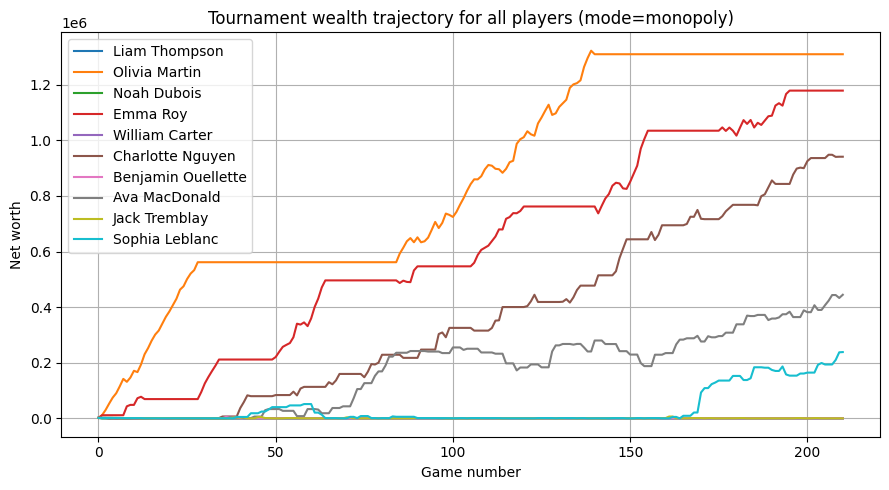

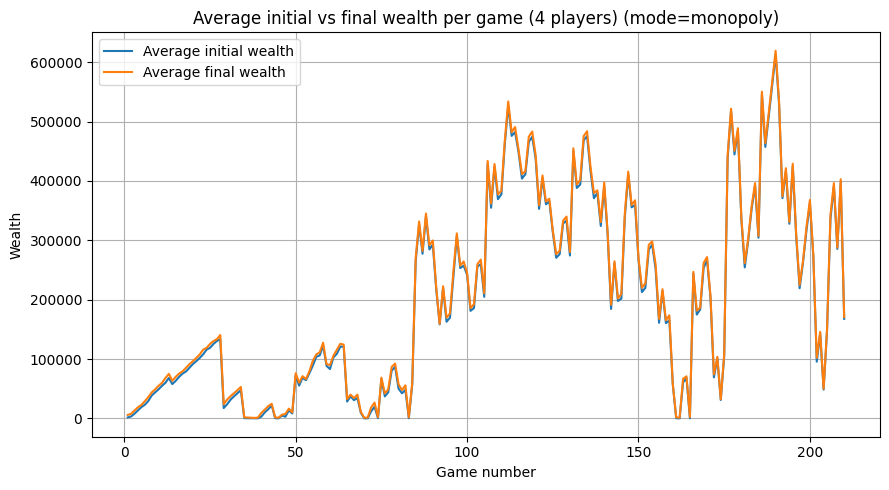

In [226]:
if __name__ == "__main__":
    random.seed(1)

    GAME_MODE = "monopoly"   # "monopoly", "prosperity", "both"
    MAX_GAMES = None         # or set e.g. 20 while testing

    # Map ID -> name for display
    id_to_name = {p["Primary_ID"]: p["Name"] for p in population_10}

    # Global tournament wealth for all 10 players (start at 1500)
    global_wealth = {p["Primary_ID"]: 1500 for p in population_10}

    all_results = []

    # --- Track wealth history over games ---
    # game_numbers[0] = 0  (before any game)
    # wealth_history[pid][k] = wealth after game k (k=0..num_games)
    wealth_history = {p["Primary_ID"]: [global_wealth[p["Primary_ID"]]]
                      for p in population_10}
    game_numbers = [0]

    # --- Tournament loop ---
    for idx, group in enumerate(itertools.combinations(population_10, 4), start=1):
        if MAX_GAMES is not None and idx > MAX_GAMES:
            break

        # Build the 4-player group with their *current* tournament wealth
        group_state = []
        for p in group:
            p_copy = dict(p)  # shallow copy
            p_copy["Net_Worth"] = global_wealth[p["Primary_ID"]]
            group_state.append(p_copy)

        # Run the game for this 4-player group
        result = simulate_group(group_state, seed=idx, mode=GAME_MODE, verbose=False)
        all_results.append(result)

        # Update global wealth for those 4 players based on final wealth from the game
        for pid, w_final in zip(result["player_ids"], result["final_wealth"]):
            global_wealth[pid] = w_final

        # Record wealth of all players after this game
        for pid in wealth_history.keys():
            wealth_history[pid].append(global_wealth[pid])
        game_numbers.append(idx)

        # ---- Printing ----
        print(f"Game {idx} [{GAME_MODE}]: players = {', '.join(result['player_names'])}")
        print("  Players in this game (initial -> final):")
        for name, w0, w1 in zip(
            result["player_names"],
            result["initial_wealth"],
            result["final_wealth"]
        ):
            print(f"    {name}: {w0} -> {w1}")

        print("  ALL players' net worth after this game:")
        for pid in sorted(global_wealth.keys()):
            print(f"    {id_to_name[pid]} (ID {pid}): {global_wealth[pid]}")

        print("  Final Gini (within this 4-player game): "
              f"{result['final_gini']:.3f}")
        print("---------------")

    print("Tournament finished.")
    print(f"Simulated {len(all_results)} games.")

    # --- Call plotting functions ---
    title_suffix = f"mode={GAME_MODE}"
    plot_tournament_wealth(wealth_history, game_numbers, id_to_name, title_suffix=title_suffix)
    plot_avg_initial_final(all_results, title_suffix=title_suffix)

#####################
# Let's play Prosperity!
# Prosperity standard-mode: play until all players reach ≥ $3000
##################################################
# Game over!: All players now have more than $3000
##################################################
Game 1 [prosperity]: players = Liam Thompson, Olivia Martin, Noah Dubois, Emma Roy
  Players in this game (initial -> final):
    Liam Thompson: 1500 -> 3421
    Olivia Martin: 1500 -> 3083
    Noah Dubois: 1500 -> 3059
    Emma Roy: 1500 -> 3188
  ALL players' net worth after this game:
    Liam Thompson (ID 1): 3421
    Olivia Martin (ID 2): 3083
    Noah Dubois (ID 3): 3059
    Emma Roy (ID 4): 3188
    William Carter (ID 5): 1500
    Charlotte Nguyen (ID 6): 1500
    Benjamin Ouellette (ID 7): 1500
    Ava MacDonald (ID 8): 1500
    Jack Tremblay (ID 9): 1500
    Sophia Leblanc (ID 10): 1500
  Final Gini (within this 4-player game): 0.000
---------------
#####################
# Let's play Prosperity!
# Prosperity standard

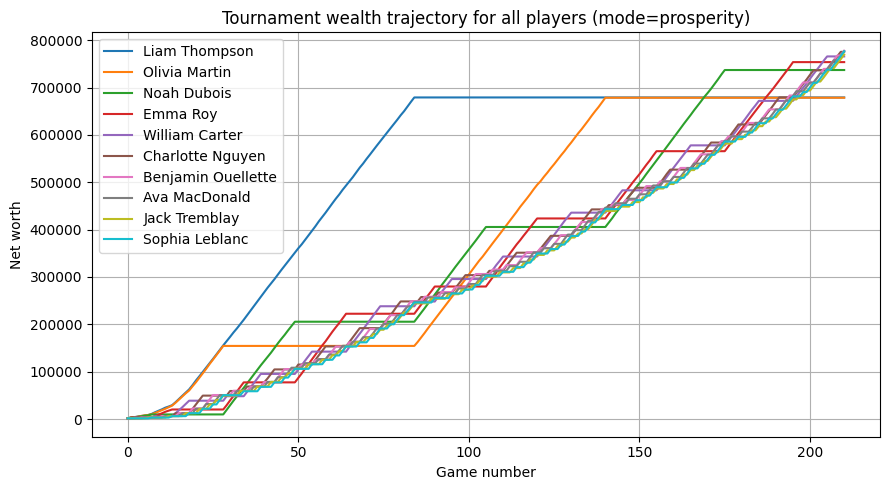

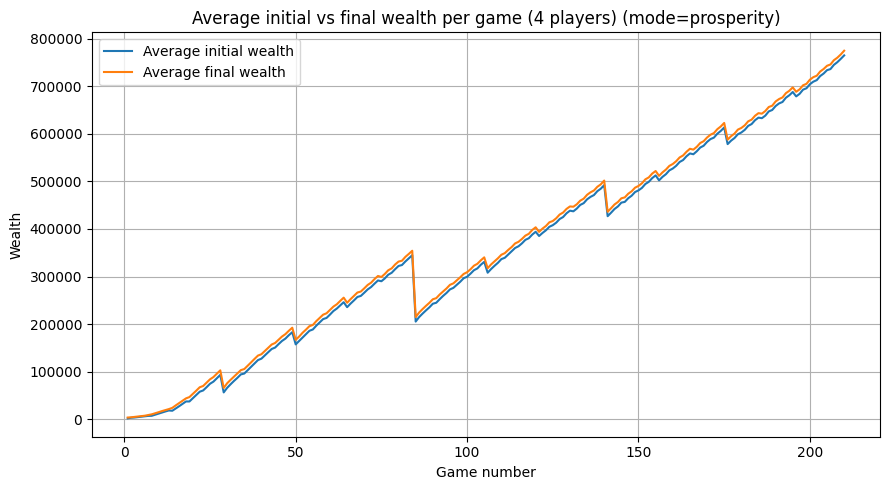

In [227]:
if __name__ == "__main__":
    random.seed(1)

    GAME_MODE = "prosperity"   # "monopoly", "prosperity", "both"
    MAX_GAMES = None         # or set e.g. 20 while testing

    # Map ID -> name for display
    id_to_name = {p["Primary_ID"]: p["Name"] for p in population_10}

    # Global tournament wealth for all 10 players (start at 1500)
    global_wealth = {p["Primary_ID"]: 1500 for p in population_10}

    all_results = []

    # --- Track wealth history over games ---
    # game_numbers[0] = 0  (before any game)
    # wealth_history[pid][k] = wealth after game k (k=0..num_games)
    wealth_history = {p["Primary_ID"]: [global_wealth[p["Primary_ID"]]]
                      for p in population_10}
    game_numbers = [0]

    # --- Tournament loop ---
    for idx, group in enumerate(itertools.combinations(population_10, 4), start=1):
        if MAX_GAMES is not None and idx > MAX_GAMES:
            break

        # Build the 4-player group with their *current* tournament wealth
        group_state = []
        for p in group:
            p_copy = dict(p)  # shallow copy
            p_copy["Net_Worth"] = global_wealth[p["Primary_ID"]]
            group_state.append(p_copy)

        # Run the game for this 4-player group
        result = simulate_group(group_state, seed=idx, mode=GAME_MODE, verbose=False)
        all_results.append(result)

        # Update global wealth for those 4 players based on final wealth from the game
        for pid, w_final in zip(result["player_ids"], result["final_wealth"]):
            global_wealth[pid] = w_final

        # Record wealth of all players after this game
        for pid in wealth_history.keys():
            wealth_history[pid].append(global_wealth[pid])
        game_numbers.append(idx)

        # ---- Printing ----
        print(f"Game {idx} [{GAME_MODE}]: players = {', '.join(result['player_names'])}")
        print("  Players in this game (initial -> final):")
        for name, w0, w1 in zip(
            result["player_names"],
            result["initial_wealth"],
            result["final_wealth"]
        ):
            print(f"    {name}: {w0} -> {w1}")

        print("  ALL players' net worth after this game:")
        for pid in sorted(global_wealth.keys()):
            print(f"    {id_to_name[pid]} (ID {pid}): {global_wealth[pid]}")

        print("  Final Gini (within this 4-player game): "
              f"{result['final_gini']:.3f}")
        print("---------------")

    print("Tournament finished.")
    print(f"Simulated {len(all_results)} games.")

    # --- Call plotting functions ---
    title_suffix = f"mode={GAME_MODE}"
    plot_tournament_wealth(wealth_history, game_numbers, id_to_name, title_suffix=title_suffix)
    plot_avg_initial_final(all_results, title_suffix=title_suffix)